In [ ]:
# !pip install gym[atari]

In [ ]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
#%matplotlib inline
import numpy as np
import keras
from keras.datasets import mnist
from collections import deque
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Add
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from statistics import mode

Using TensorFlow backend.


In [ ]:
env = gym.make('CartPole-v1')
env.reset()

array([-0.02403311, -0.01843994,  0.01024354,  0.00161472])

In [ ]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In [ ]:
action = 1
print(action)
observation, reward, done, info  = env.step(action)
print(observation)  

1
[-0.0244019   0.17653362  0.01027583 -0.28781872]


In [ ]:
observation.shape

(4,)

In [ ]:
# plt.imshow(env.render('rgb_array'))
#plt.show()

In [ ]:
obs = observation.reshape(-1,4)
obs

array([[-0.0244019 ,  0.17653362,  0.01027583, -0.28781872]])

In [ ]:
batch_size = 32
outputs = env.action_space.n
input_size = observation.shape[0]
M = 1000
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
actions =  env.action_space.n
num_classes = env.action_space.n
_steps = 0
tot_reward =0
gamma = 0.95
input_shape = (input_size,1)
reward_array =[]
epsilon_array =[]
#epochs=4
learning = 0.001
tau = 0.1

In [ ]:
memory = deque(maxlen=20000) 
memory

deque([])

In [ ]:
DQN_train_net = Sequential()
#train_net.add(Flatten())
DQN_train_net.add(Dense(24, input_dim = input_size,  activation='relu'))
DQN_train_net.add(Dense(24, activation='relu'))
DQN_train_net.add(Dense(num_classes, activation='linear'))

DQN_train_net.compile(loss='mse', #keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd',#keras.optimizers.Adadelta(),
              )

DQN_target_net = Sequential() 
DQN_target_net.add(Dense(24, input_dim = input_size,  activation='relu'))
DQN_target_net.add(Dense(24, activation='relu'))
DQN_target_net.add(Dense(num_classes, activation='linear'))

DQN_target_net.compile(loss='mse',#'mse',#keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd', #keras.optimizers.Adadelta(),
              )
DQN_train_weights = DQN_train_net.get_weights()
DQN_target_net.set_weights(DQN_train_weights)

In [ ]:
DDQN_train_net = Sequential()
#train_net.add(Flatten())
DDQN_train_net.add(Dense(24, input_dim = input_size,  activation='relu'))
DDQN_train_net.add(Dense(24, activation='relu'))
DDQN_train_net.add(Dense(num_classes, activation='linear'))

DDQN_train_net.compile(loss='mse', #keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd',#keras.optimizers.Adadelta(),
              )

DDQN_target_net = Sequential() 
DDQN_target_net.add(Dense(24, input_dim = input_size,  activation='relu'))
DDQN_target_net.add(Dense(24, activation='relu'))
DDQN_target_net.add(Dense(num_classes, activation='linear'))

DDQN_target_net.compile(loss='mse',#'mse',#keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd', #keras.optimizers.Adadelta(),
              )
DDQN_train_weights = DDQN_train_net.get_weights()
DDQN_target_net.set_weights(DDQN_train_weights)


In [ ]:
input_layer = Input((input_size,))
train_1 = Dense(24, activation='relu')(input_layer)
train_2 = Dense(24, activation='relu')(train_1)
val_layer = Dense(1)(train_2)

advan_layer = Dense(actions)(train_2)
q_vals  = Add()([val_layer, advan_layer])

Dueling_train_net = keras.Model(input_layer, q_vals)
Dueling_train_net.compile(loss='mse', 
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd',#keras.optimizers.Adadelta(),
              )


target_input_layer = Input((input_size,))
target_1 = Dense(24, activation='relu')(target_input_layer)
target_2 = Dense(24, activation='relu')(target_1)
target_val_layer = Dense(1)(target_2)

target_advan_layer = Dense(actions)(target_2)
target_q_vals  = Add()([target_val_layer, target_advan_layer])

Dueling_target_net = keras.Model(target_input_layer, target_q_vals)
Dueling_target_net.compile(loss='mse', 
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd',#keras.optimizers.Adadelta(),
              )


Dueling_train_weights = Dueling_train_net.get_weights()
Dueling_target_net.set_weights(Dueling_train_weights)

In [ ]:
train_model = Sequential([
  Dense(24, activation='relu', input_shape=(4,)),
  Dense(24, activation='relu'),
  Dense(2, activation='relu'),
])
target_model = Sequential([
  Dense(24, activation='relu', input_shape=(4,)),
  Dense(24, activation='relu'),
  Dense(2, activation='relu'),
])
train_model.compile(
  optimizer='sgd',
  loss='huber_loss',
  metrics=['accuracy'],
)
target_model.compile(
  optimizer='sgd',
  loss='huber_loss',
  metrics=['accuracy'],
)

In [ ]:
policy_net = Sequential() 
policy_net.add(Dense(24, input_dim = input_size,  activation='relu'))
policy_net.add(Dense(12, activation='relu'))
policy_net.add(Dense(num_classes, activation='softmax'))

policy_net.compile(loss= keras.losses.categorical_crossentropy,
             optimizer= keras.optimizers.Adam(lr = learning) #'sgd',#keras.optimizers.Adadelta(),
              )

In [ ]:
def DQN_training(memory,e):
    train_data = random.sample(list(memory),batch_size)
    input_x = []
    input_y = []
    for s1,a,r,s2,done in train_data: 
        y = DQN_train_net.predict(s1.reshape(-1,4)) 
        if done : 
            y[0][a] = r 
        else:
            y[0][a] = r +  gamma * np.max(DQN_target_net.predict(s2.reshape(-1,4))[0]) 
        input_x.append(s1)
        input_y.append(y[0]) 
        DQN_train_net.fit(s1.reshape(-1,4), y, verbose=0)
    #train_net.fit(np.array(input_x), np.array(input_y),verbose=0)
    if(e % 5 == 0):
        DQN_train_weights = DQN_train_net.get_weights()
        DQN_target_net.set_weights(DQN_train_weights) 
#     if epsilon > epsilon_min:
#         epsilon *= epsilon_decay
#     epsilon_array.append(epsilon)
    return  

In [ ]:
def DDQN_training(memory,e):
    train_data = random.sample(list(memory),batch_size)
    input_x = []
    input_y = []
    for s1,a,r,s2,done in train_data:
        #print(s1.shape)
        y = DDQN_train_net.predict(s1.reshape(-1,4))
        # y = np.array(y)
        if done : 
            y[0][a] = r 
        else:                                        
            target_action = np.argmax(DDQN_target_net.predict(s2.reshape(-1,4)))                    
            Qval = DDQN_train_net.predict(s2.reshape(-1,4))[0][target_action]                    
            y[0][a] = r +  gamma * Qval 
        input_x.append(s1)
        input_y.append(y[0])
        DDQN_train_net.fit(s1.reshape(-1,4), y,verbose=0)
                #train_net.fit(np.array(input_x), np.array(input_y),verbose=0)
    if(e % 5 == 0):    
        DDQN_train_weights = DDQN_train_net.get_weights()
        DDQN_target_net_weights = DDQN_target_net.get_weights()
        counter = 0
        for DDQN_train_weight, DDQN_target_weight in zip(DDQN_train_weights,DDQN_target_net_weights):
            DDQN_target_weight = DDQN_target_weight * (1-tau) + DDQN_train_weight * tau
            DDQN_target_net_weights[counter] = DDQN_target_weight
            counter += 1
        DDQN_target_net.set_weights(DDQN_target_net_weights)
    return

In [ ]:
def Dueling_training(memory, e):
    train_data = random.sample(list(memory),batch_size)
    input_x = []
    input_y = []
    for s1,a,r,s2,done in train_data: 
        y = Dueling_train_net.predict(s1.reshape(-1,4)) 
        if done : 
            y[0][a] = r 
        else:
            y[0][a] = r +  gamma * np.max(Dueling_target_net.predict(s2.reshape(-1,4))[0]) 
        input_x.append(s1)
        input_y.append(y[0]) 
        Dueling_train_net.fit(s1.reshape(-1,4), y, verbose=0)
    #train_net.fit(np.array(input_x), np.array(input_y),verbose=0)
    if(e % 5 == 0):
        Dueling_train_weights = Dueling_train_net.get_weights()
        Dueling_target_net.set_weights(Dueling_train_weights) 
#     if epsilon > epsilon_min:
#         epsilon *= epsilon_decay
#     epsilon_array.append(epsilon)
    return  

2 15.0
3 41.0
4 13.0
5 16.0
6 12.0
7 17.0
8 20.0
9 28.0
10 19.0
11 29.0
12 10.0
13 28.0
14 24.0
15 20.0
16 16.0
17 25.0
18 45.0
19 42.0
20 13.0
21 14.0
22 23.0
23 17.0
24 16.0
25 13.0
26 21.0
27 23.0
28 14.0
29 23.0
30 56.0
31 11.0
32 14.0
33 12.0
34 10.0
35 13.0
36 13.0
37 36.0
38 31.0
39 12.0
40 10.0
41 36.0
42 17.0
43 25.0
44 12.0
45 16.0
46 22.0
47 14.0
48 24.0
49 12.0
50 30.0
51 17.0
52 18.0
53 13.0
54 14.0
55 17.0
56 26.0
57 27.0
58 14.0
59 34.0
60 28.0
61 12.0
62 30.0
63 39.0
64 17.0
65 11.0
66 42.0
67 39.0
68 16.0
69 10.0
70 10.0
71 31.0
72 12.0
73 24.0
74 12.0
75 18.0
76 17.0
77 22.0
78 38.0
79 36.0
80 13.0
81 8.0
82 11.0
83 15.0
84 16.0
85 51.0
86 13.0
87 15.0
88 21.0
89 10.0
90 10.0
91 11.0
92 22.0
93 23.0
94 15.0
95 19.0
96 10.0
97 19.0
98 10.0
99 12.0
100 12.0
101 21.0
102 23.0
103 19.0
104 38.0
105 29.0
106 17.0
107 15.0
108 15.0
109 13.0
110 15.0
111 14.0
112 16.0
113 19.0
114 9.0
115 19.0
116 39.0
117 20.0
118 50.0
119 28.0
120 14.0
121 45.0
122 17.0
123 38.0
124 30.0
1

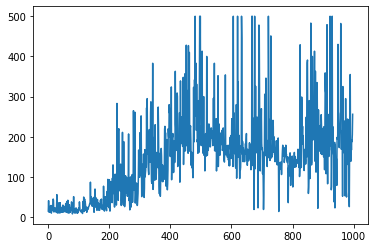

In [ ]:
memory.clear()
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
for e in range(M):  
    s1 = env.reset()
    done = False
    tot_reward = 0
    while not done :  
        ran = np.random.rand()# (random.randint(1,100)) / 100
        if(ran < epsilon):
            action = env.action_space.sample()
        else: 
            DQN_action_val = DQN_train_net.predict(s1.reshape(-1,4))  
            action = np.argmax(DQN_action_val[0])
        #print(e,action)
        #env.render()
        s2, reward, done, inf = env.step(action) 
        _steps += 1
        tot_reward += reward
        memory.append([s1,action,reward,s2,done])
        s1 = s2
    if len(memory) < batch_size : 
        continue
    else:
        DQN_training(memory,e)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    epsilon_array.append(epsilon)   
    reward_array.append(tot_reward)
    #print(tot_reward)
    print(e,tot_reward)
plt.plot(reward_array)

1 43.0
2 24.0
3 37.0
4 23.0
5 16.0
6 14.0
7 9.0
8 16.0
9 8.0
10 14.0
11 11.0
12 11.0
13 54.0
14 47.0
15 14.0
16 11.0
17 20.0
18 16.0
19 19.0
20 25.0
21 30.0
22 16.0
23 15.0
24 36.0
25 18.0
26 19.0
27 14.0
28 14.0
29 27.0
30 13.0
31 28.0
32 20.0
33 17.0
34 16.0
35 45.0
36 25.0
37 23.0
38 16.0
39 33.0
40 28.0
41 23.0
42 27.0
43 21.0
44 9.0
45 22.0
46 12.0
47 12.0
48 10.0
49 23.0
50 26.0
51 15.0
52 20.0
53 44.0
54 28.0
55 30.0
56 12.0
57 14.0
58 13.0
59 9.0
60 15.0
61 15.0
62 21.0
63 13.0
64 12.0
65 22.0
66 11.0
67 13.0
68 21.0
69 18.0
70 11.0
71 13.0
72 12.0
73 13.0
74 19.0
75 41.0
76 24.0
77 40.0
78 19.0
79 16.0
80 17.0
81 12.0
82 13.0
83 13.0
84 14.0
85 12.0
86 10.0
87 12.0
88 21.0
89 10.0
90 10.0
91 13.0
92 18.0
93 14.0
94 10.0
95 12.0
96 8.0
97 9.0
98 14.0
99 14.0
100 19.0
101 15.0
102 10.0
103 16.0
104 11.0
105 9.0
106 21.0
107 18.0
108 22.0
109 10.0
110 12.0
111 14.0
112 11.0
113 25.0
114 11.0
115 15.0
116 11.0
117 9.0
118 9.0
119 12.0
120 12.0
121 18.0
122 12.0
123 16.0
124 11.0
1

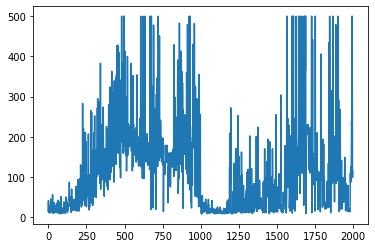

In [ ]:
memory.clear()
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
for e in range(M):  
    s1 = env.reset()
    done = False
    tot_reward = 0
    while not done :  
        ran = np.random.rand()# (random.randint(1,100)) / 100
        if(ran < epsilon):
            action = env.action_space.sample()
        else: 
            DDQN_action_val = DDQN_train_net.predict(s1.reshape(-1,4))  
            action = np.argmax(DDQN_action_val[0])
        #print(e,action)
        #env.render()
        s2, reward, done, inf = env.step(action) 
        _steps += 1
        tot_reward += reward
        memory.append([s1,action,reward,s2,done])
        s1 = s2
    if len(memory) < batch_size : 
        continue
    else:
        DDQN_training(memory,e)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    epsilon_array.append(epsilon)   
    reward_array.append(tot_reward)
    #print(tot_reward)
    print(e,tot_reward)
plt.plot(reward_array)

0 33.0
1 13.0
2 28.0
3 18.0
4 15.0
5 16.0
6 14.0
7 15.0
8 10.0
9 10.0
10 39.0
11 11.0
12 14.0
13 19.0
14 14.0
15 29.0
16 15.0
17 33.0
18 13.0
19 10.0
20 22.0
21 18.0
22 11.0
23 18.0
24 13.0
25 22.0
26 22.0
27 17.0
28 12.0
29 36.0
30 14.0
31 31.0
32 15.0
33 14.0
34 18.0
35 11.0
36 14.0
37 12.0
38 9.0
39 9.0
40 16.0
41 17.0
42 12.0
43 11.0
44 10.0
45 31.0
46 18.0
47 20.0
48 10.0
49 11.0
50 18.0
51 38.0
52 61.0
53 14.0
54 29.0
55 11.0
56 11.0
57 18.0
58 16.0
59 29.0
60 13.0
61 19.0
62 17.0
63 13.0
64 22.0
65 14.0
66 31.0
67 22.0
68 38.0
69 13.0
70 19.0
71 16.0
72 29.0
73 19.0
74 20.0
75 16.0
76 18.0
77 29.0
78 21.0
79 62.0
80 22.0
81 15.0
82 15.0
83 30.0
84 32.0
85 26.0
86 31.0
87 33.0
88 51.0
89 89.0
90 54.0
91 54.0
92 72.0
93 61.0
94 20.0
95 17.0
96 30.0
97 32.0
98 31.0
99 28.0
100 42.0
101 32.0
102 13.0
103 16.0
104 17.0
105 21.0
106 36.0
107 39.0
108 22.0
109 25.0
110 42.0
111 17.0
112 63.0
113 27.0
114 43.0
115 53.0
116 73.0
117 23.0
118 34.0
119 36.0
120 86.0
121 23.0
122 69.0
123 2

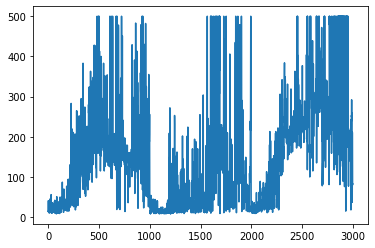

In [ ]:
memory.clear()
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
for e in range(M):  
    s1 = env.reset()
    done = False
    tot_reward = 0
    while not done :  
        ran = np.random.rand()# (random.randint(1,100)) / 100
        if(ran < epsilon):
            action = env.action_space.sample()
        else: 
            Dueling_action_val = Dueling_train_net.predict(s1.reshape(-1,4))  
            action = np.argmax(Dueling_action_val[0])
        #print(e,action)
        #env.render()
        s2, reward, done, inf = env.step(action) 
        _steps += 1
        tot_reward += reward
        memory.append([s1,action,reward,s2,done])
        s1 = s2
    if len(memory) < batch_size : 
        continue
    else:
        Dueling_training(memory,e)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    epsilon_array.append(epsilon)   
    reward_array.append(tot_reward)
    #print(tot_reward)
    print(e,tot_reward)
plt.plot(reward_array)

0 17
1 18
2 20
3 14
4 8
5 9
6 20
7 28
8 21
9 11
10 11
11 23
12 19
13 42
14 19
15 17
16 29
17 17
18 11
19 12
20 13
21 14
22 18
23 39
24 57
25 11
26 24
27 13
28 16
29 23
30 12
31 46
32 19
33 15
34 14
35 28
36 10
37 9
38 18
39 36
40 23
41 14
42 16
43 11
44 15
45 15
46 26
47 30
48 24
49 18
50 17
51 10
52 34
53 58
54 24
55 9
56 36
57 14
58 10
59 13
60 11
61 55
62 28
63 20
64 34
65 12
66 9
67 8
68 15
69 8
70 23
71 14
72 27
73 21
74 46
75 28
76 36
77 27
78 34
79 12
80 18
81 21
82 17
83 9
84 8
85 9
86 15
87 21
88 28
89 28
90 24
91 75
92 13
93 19
94 19
95 15
96 29
97 9
98 19
99 34
100 13
101 12
102 11
103 15
104 11
105 26
106 13
107 18
108 15
109 24
110 24
111 11
112 28
113 11
114 33
115 10
116 41
117 80
118 26
119 23
120 11
121 33
122 18
123 36
124 13
125 63
126 15
127 14
128 56
129 39
130 31
131 11
132 19
133 57
134 73
135 48
136 11
137 29
138 19
139 39
140 18
141 8
142 17
143 61
144 25
145 11
146 12
147 36
148 27
149 16
150 54
151 32
152 32
153 44
154 64
155 8
156 75
157 40
158 16
159 57
160

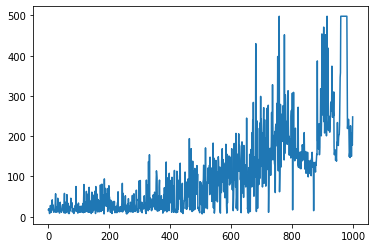

In [ ]:

action_space=[0,1]
memory = deque(maxlen=50000)
priority = deque(maxlen=50000)
alpha=0.1
beta=-0.4
maxp=0.1
maxw=0
episode_count=1000
plot_list=[]
for episode in range(0,episode_count):
    epsilon = ((episode_count-episode)/episode_count)*100
    env.reset()
    t=0
    c=0
    action=env.action_space.sample()
    observation, reward, done, info = env.step(action)
    target_model.set_weights(train_model.get_weights())
    while(t<500):
        maxval=0
        r=random.randrange(100)
        prev_obs=np.around(observation,3)
        if(r<epsilon):
            best_act=env.action_space.sample()
            observation, reward, done, info = env.step(best_act)
        else:
            l=np.around(observation,3).reshape(-1,4)
            val=train_model.predict(l)
            best_act=np.argmax(val[0])
            observation, reward, done, info = env.step(best_act)
        if(done==True):
            l=prev_obs.reshape(-1,4)
            k_y=np.zeros((1))-1
            reward=-1
            plot_list.append(t)
            memory_block=[prev_obs,best_act,reward,np.around(observation,3)]
            memory.append(memory_block)
            priority.append(maxp)
            break
        memory_block=[prev_obs,best_act,reward,np.around(observation,3)]
        memory.append(memory_block)
        priority.append(maxp)
        if(len(memory)>=50):
            mini_batch=list(np.argsort(np.asarray(priority))[-32:])
            totalp=np.sum(np.power(np.asarray(priority),alpha))
            for every_sample in mini_batch:
                tp=priority[every_sample]**alpha/totalp
                pl=memory[every_sample][0].reshape(-1,4)
                nl=memory[every_sample][3].reshape(-1,4)
                y_val=memory[every_sample][2]+0.9*np.amax(target_model.predict(nl)[0])
                q=target_model.predict(pl)
                q[0][memory[every_sample][1]]=y_val
                act=memory[every_sample][1]           
                priority[every_sample]=abs(y_val-train_model.predict(pl)[0][act])
                if(priority[every_sample]>maxp):
                  maxp=priority[every_sample]
                train_model.fit(pl,q,verbose=0)
            c=c+1
            if(c%20==0):
                target_model.set_weights(train_model.get_weights())
        t=t+1  
    print(episode,t)

plt.plot(plot_list)


In [ ]:
def predict_action(state):
    action_prob_vals = policy_net.predict(state.reshape(-1,input_size))
    action_prob_vals_list  = action_prob_vals.flatten()
    action_prob_vals_list /= np.sum(action_prob_vals_list)
    _max_prob_action = np.random.choice(actions,1, p=action_prob_vals_list )[0]    
    return  _max_prob_action,action_prob_vals_list

0 16.0
1 30.0
2 8.0
3 24.0
4 15.0
5 16.0
6 11.0
7 16.0
8 11.0
9 11.0
10 22.0
11 17.0
12 11.0
13 47.0
14 33.0
15 10.0
16 67.0
17 20.0
18 41.0
19 24.0
20 45.0
21 40.0
22 18.0
23 9.0
24 27.0
25 88.0
26 15.0
27 41.0
28 19.0
29 15.0
30 32.0
31 16.0
32 31.0
33 14.0
34 29.0
35 19.0
36 42.0
37 22.0
38 30.0
39 10.0
40 33.0
41 16.0
42 44.0
43 21.0
44 56.0
45 50.0
46 35.0
47 17.0
48 14.0
49 13.0
50 20.0
51 19.0
52 23.0
53 22.0
54 12.0
55 64.0
56 18.0
57 18.0
58 18.0
59 12.0
60 19.0
61 12.0
62 38.0
63 32.0
64 22.0
65 20.0
66 28.0
67 19.0
68 29.0
69 30.0
70 13.0
71 19.0
72 34.0
73 31.0
74 13.0
75 33.0
76 12.0
77 13.0
78 61.0
79 13.0
80 36.0
81 49.0
82 15.0
83 12.0
84 16.0
85 16.0
86 45.0
87 24.0
88 17.0
89 23.0
90 21.0
91 18.0
92 51.0
93 11.0
94 19.0
95 36.0
96 15.0
97 15.0
98 10.0
99 20.0
100 67.0
101 42.0
102 19.0
103 12.0
104 15.0
105 125.0
106 13.0
107 10.0
108 28.0
109 25.0
110 18.0
111 26.0
112 18.0
113 30.0
114 23.0
115 15.0
116 21.0
117 58.0
118 34.0
119 13.0
120 15.0
121 26.0
122 62.0
123 

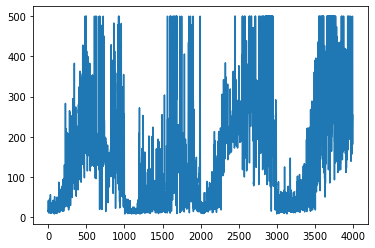

In [ ]:
for e in range(M):  
    s1 = env.reset()
    done = False
    tot_reward = 0
    episode_rewards = []
    episode_probs = []
    episode_states = []
    episode_gradients = []
    
    while not done :  
        action, act_probs = predict_action(s1) 
        s2, reward, done, inf = env.step(action) 
        
        actions_arr = np.zeros(actions, np.float32)
        actions_arr[action] = 1
        grad_arr = actions_arr - act_probs
        episode_gradients.append(grad_arr)
        episode_rewards.append(reward)
        episode_probs.append(act_probs)
        episode_states.append(s1)
        
        _steps += 1
        tot_reward += reward 
        s1 = s2
        
        if done:
            episode_states = np.vstack(episode_states)
            
            episode_gradients = np.vstack(episode_gradients)
            episode_rewards = np.vstack(episode_rewards)
            
            discount_rewards = []
            ctr = 0
            for r in episode_rewards[::-1]:
                ctr = (ctr * gamma)  + r
                discount_rewards.insert(0,ctr)
#             for i in range(len(episode_rewards)):
#                 G = 0
#                 power = 0
#                 for r in episode_rewards[i:]:
#                     G = G + (gamma**power) * r
#                     power = power + 1
#                 discount_rewards.append(G)
            avg_rewards = np.mean(discount_rewards)
            std_re = np.std(discount_rewards)
            discount_rewards = (discount_rewards - avg_rewards)/(std_re + 1e-7)
            
            episode_gradients *= discount_rewards
            
            episode_gradients = alpha * np.vstack([episode_gradients]) + episode_probs
            policy_net.train_on_batch(episode_states,episode_gradients)
            episode_rewards = []
            episode_probs = []
            episode_states = []
            episode_gradients = []
    reward_array.append(tot_reward)
    #print(tot_reward)
    print(e,tot_reward)
plt.plot(reward_array)

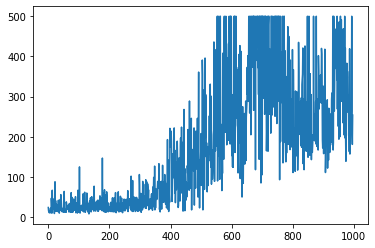

In [ ]:
plt.plot(reward_array[3000:4000])

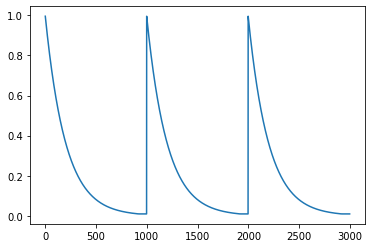

In [ ]:
 plt.plot(epsilon_array)

In [ ]:
def policy(state,epsilon=0):
    #epsilon = max(epsilon_min,epsilon)
    #print(epsilon)
    ran = np.random.rand()# (random.randint(1,100)) / 100
    if (ran < epsilon):
        action = env.action_space.sample()
        return action
    else: 
        DQN_action_val = DQN_train_net.predict(state.reshape(-1,4))
        DDQN_action_val = DDQN_train_net.predict(state.reshape(-1,4))
        Dueling_action_val = Dueling_train_net.predict(state.reshape(-1,4))
        PER_action_val=target_model.predict(state.reshape(-1,4))
        policy_action_val = policy_net.predict(s1.reshape(-1,4))
        
        
        DQN_max_action = np.argmax(DQN_action_val[0])
        DDQN_max_action = np.argmax(DDQN_action_val[0])
        Dueling_max_action = np.argmax(Dueling_action_val[0])
        PER_max_act=np.argmax(val[0])
        policy_max_act = np.argmax(policy_action_val[0])
        actions_list = []
        actions_list.append(DQN_max_action)
        actions_list.append(DDQN_max_action)
        actions_list.append(Dueling_max_action)
        actions_list.append(PER_max_act)
        actions_list.append(policy_max_act)
        best_action = mode(actions_list)
        # print(actions_list)
      #print(action_val)
    return  best_action  

<h2>Play Cartpole Episode using Trained Neural Network
</h2>

391.0
500.0
500.0
392.0
500.0
500.0
441.0
353.0
500.0
358.0
500.0
379.0
365.0
500.0
381.0
500.0
456.0
500.0
393.0
408.0
367.0
500.0
500.0
500.0
443.0
500.0
500.0
500.0
317.0
438.0
500.0
290.0
448.0
275.0
244.0
500.0
395.0
500.0
500.0
500.0
375.0
500.0
500.0
500.0
386.0
500.0
500.0
365.0
500.0
454.0
500.0
500.0
366.0
492.0
500.0
466.0
500.0
349.0
500.0
382.0
408.0
360.0
500.0
500.0
438.0
500.0
374.0
427.0
403.0
500.0
340.0
500.0
500.0
459.0
290.0
457.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
404.0
337.0
360.0
311.0
394.0
289.0
500.0
500.0
500.0
403.0
402.0
392.0
500.0
322.0
418.0
500.0
426.0


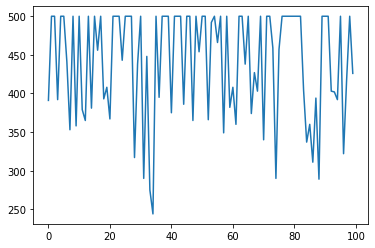

In [ ]:
#DQN_model_perfectplay is the saved model which is perfectly trained and will balance the pole till it reaches the goal.
#neural_net = keras.models.load_model('DQN_model_perfectplay')
game_reward = 0
plot_rewards=[]
s1 = env.reset()
done = False
i = 0
for x in range(0,100):
  game_reward = 0
  done = False
  s1 = env.reset()
  while not done:
      # action_arr = DQN_train_net.predict(s1.reshape(-1,4))
      # print(policy(s1.reshape(-1,4)))
      action_arr = policy(s1.reshape(-1,4))
      
      # print(action_arr)
      # action = np.argmax(action_arr)
      s2, reward, done, _ = env.step(action_arr)
      game_reward += reward
      s1 = s2
      # plt.imshow(env.render('rgb_array'))
      #plt.savefig('cartpole'+ str(i))
      i = i + 1
  print(game_reward)
  plot_rewards.append(game_reward)
plt.plot(plot_rewards)

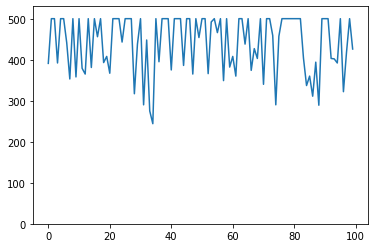

In [ ]:
plt.ylim(0,530)
plt.plot(plot_rewards)

In [ ]:
DQN_train_net.save("DQN_model")
DDQN_train_net.save("DDQN_model")
Dueling_train_net.save("Dueling_model")
target_model.save("PER_DQN_model")
policy_net.save("Policy_model")